In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from substs_loading import load_substs

In [2]:
names = ['<mask><mask><mask>-(а-также-T)-2ltr3f_topk150_fixspacesTrue.npz', 
         '<mask><mask>-(а-также-T)-2ltr2f_topk150_fixspacesTrue.npz', 
         '<mask>-(а-также-T)-2ltr1f_topk150_fixspacesTrue.npz',
         'T-(а-также-<mask>)-2ltr1f_topk150_fixspacesTrue.npz',
         'T-(а-также-<mask><mask>)-2ltr2f_topk150_fixspacesTrue.npz',
         'T-(а-также-<mask><mask><mask>)-2ltr3f_topk150_fixspacesTrue.npz']

root = 'xlm/russe_bts-rnc/train_1-limitNone-maxexperwordNone/modelNone/'

Загружаем в список **dfs** информацию из файлов $\text{<mask>-(а-также-T)...}$, $\text{<mask><mask>-(а-также-T)...}$, $\text{<mask><mask><mask>-(а-также-T)...}$ с помощью **load_substs**.

In [3]:
dfs = []

for i in range(3):
    path = root + names[2-i]
    df = load_substs(path)
    dfs.append(df)

4.1961669921875e-05 Loading substs from  xlm/russe_bts-rnc/train_1-limitNone-maxexperwordNone/modelNone/<mask>-(а-также-T)-2ltr1f_topk150_fixspacesTrue.npz
(3491, 150) <U16 (3491, 150) float32
0.6195881366729736 Loading examples from  xlm/russe_bts-rnc/train_1-limitNone-maxexperwordNone/modelNone/<mask>-(а-также-T)-2ltr1f_topk150_fixspacesTrue.npz.input
0.0001220703125 Loading substs from  xlm/russe_bts-rnc/train_1-limitNone-maxexperwordNone/modelNone/<mask><mask>-(а-также-T)-2ltr2f_topk150_fixspacesTrue.npz
(3491, 150) <U31 (3491, 150) float32
1.1236064434051514 Loading examples from  xlm/russe_bts-rnc/train_1-limitNone-maxexperwordNone/modelNone/<mask><mask>-(а-также-T)-2ltr2f_topk150_fixspacesTrue.npz.input
5.817413330078125e-05 Loading substs from  xlm/russe_bts-rnc/train_1-limitNone-maxexperwordNone/modelNone/<mask><mask><mask>-(а-также-T)-2ltr3f_topk150_fixspacesTrue.npz
(3491, 150) <U42 (3491, 150) float32
0.911862850189209 Loading examples from  xlm/russe_bts-rnc/train_1-limitN

В словаре **topkS** ключом является конкретное значение topK, а значением - массив, в i-ом элементе, которого аккумулируется количество подстановок из файла с i+1 маской.

In [4]:
topkS = {i: [0 ,0, 0] for i in range(50, 301, 50)}

1. Функция **numbering** превращает пары, которые хранятся в элементах списка substs_probs, из **(proba, word)** в **(proba, word, count of masks)**.   
Это нужно тогда, когда мы для одного конкретного предложения соединили и отсортировали все подстановки, различать из какого именно файла конкретная подстановка.

2. Функция **counting** подсчитывает в массиве всех подстановок(из всех 3ех файлов) количество подстановок из 1ой маски, 2ух и 3ех, в таком же формате, как и значения в словаре **topkS**.

In [5]:
def numbering(array, number):
    return [(el[0], el[1], number) for el in array]

def counting(array):
    res = [0, 0, 0]
    for i in range(len(array)):
        res[array[i][2]] += 1
    return res

Здесь собственно и происходит нужный нам подсчет.  
Для каждого примера "сливаем" подстановки из всех файлов в один список(строчки 4-6), не забывая пронумеровать подстановки с помощью **numbering**. Далее, в зависимости от topK, вычисляем в отсортированных подстановках количество подстановок для каждого количества масок и аккумулируем это в **topkS**.

In [6]:
topK_S = range(50, 301, 50)


for i in range(len(dfs[0])):
    tmp = numbering(dfs[0].substs_probs[i], 0)
    tmp.extend(numbering(dfs[1].substs_probs[i], 1))
    tmp.extend(numbering(dfs[2].substs_probs[i], 2))
    for topK in topK_S:
        t = counting(sorted(tmp, key=lambda x: -x[0])[:topK])
        topkS[topK][0] += t[0]
        topkS[topK][1] += t[1]
        topkS[topK][2] += t[2]

Теперь посчитаем среднюю долю подстановок из каждого файла на одно предложение при заданном topK, просто поделив каждое значение **topkS** на соответсвующий topK * количество предложений. 

In [7]:
for key in topkS:
    for i in range(3):
        topkS[key][i] /= key*len(dfs[0])

In [8]:
p_0, p_1, p_2 = zip(*topkS.values()) 

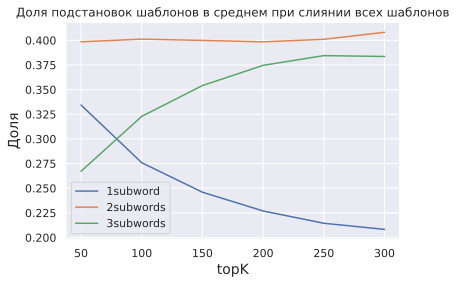

In [9]:
plt.title('Доля подстановок шаблонов в среднем при слиянии всех шаблонов')
plt.plot(p_0, label='1subword')
plt.plot(p_1, label='2subwords')
plt.plot(p_2, label='3subwords')
plt.legend()
plt.ylabel('Доля', fontsize=14)
plt.xlabel('topK', fontsize=14)
plt.xticks(ticks=range(6), labels=range(50, 301, 50))
plt.show()

Для того, чтобы построить boxplot соберем информацию немного по-другому. Создадим табличку, в i-ой строчке, которой лежит доля подстановок из number масок при topK, number и topK

In [15]:
topK_S = range(50, 301, 50)
values_for_df = []
topks_for_df = []
numbers_for_df = []


for i in range(len(dfs[0])):
    tmp = numbering(dfs[0].substs_probs[i], 0)
    tmp.extend(numbering(dfs[1].substs_probs[i], 1))
    tmp.extend(numbering(dfs[2].substs_probs[i], 2))
    for topK in topK_S:
        t = counting(sorted(tmp, key=lambda x: -x[0])[:topK])
        
        for j in range(3):
            values_for_df.append(t[j] / topK)
            topks_for_df.append(topK)
            numbers_for_df.append(str(j+1)+'subword')

In [16]:
data = pd.DataFrame({'value':values_for_df, 'topK':topks_for_df, 'number':numbers_for_df})

In [18]:
data.head()

,value,topK,number
0,0.28,50,1subword
1,0.38,50,2subword
2,0.34,50,3subword
3,0.26,100,1subword
4,0.36,100,2subword


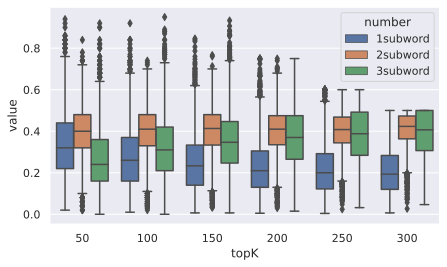

In [19]:
plt.figure(figsize=(7, 4))
sns.boxplot(x='topK', y='value', hue='number', data=data)
plt.show()